## Unzip the files

In [2]:
!unzip '/content/Cardiac-Video-Sequence.zip'

Archive:  /content/Cardiac-Video-Sequence.zip
   creating: Cardiac-Video-Sequence/
  inflating: __MACOSX/._Cardiac-Video-Sequence  
  inflating: Cardiac-Video-Sequence/2023-11-15-cine-myo-masks-and-TOS.npy  
  inflating: __MACOSX/Cardiac-Video-Sequence/._2023-11-15-cine-myo-masks-and-TOS.npy  
  inflating: Cardiac-Video-Sequence/README.txt  
  inflating: __MACOSX/Cardiac-Video-Sequence/._README.txt  


# Data Preprocessing

In [3]:
import numpy as np

data = np.load('/content/Cardiac-Video-Sequence/2023-11-15-cine-myo-masks-and-TOS.npy', allow_pickle=True)

mask_volume = []
TOS_volume = []
time_stamps = []

for i in range(128):
    mask_volume.append(data[i]['cine_lv_myo_masks_cropped'])   # Get the myocardium mask of slice 0. It should be a (H, W, n_frames) volume
    TOS_volume.append(data[i]['TOS'])  # Get the TOS curve of slice 0. It should be a (126, n_frames) 2D array

print('Data:', mask_volume[0].shape)
print('Ground Truth', TOS_volume[0].shape)


Data: (80, 80, 25)
Ground Truth (126,)


In [4]:
import numpy as np

# Load data
data = np.load('/content/Cardiac-Video-Sequence/2023-11-15-cine-myo-masks-and-TOS.npy', allow_pickle=True)

mask_volume = []
TOS_volume = []

for i in range(128):
    mask = data[i]['cine_lv_myo_masks_cropped']   # Shape: (H, W, n_frames)
    TOS = data[i]['TOS']                          # Shape: (126,)

    # Example preprocessing step: averaging across the time dimension
    mask_avg = np.mean(mask, axis=2)              # Shape: (H, W)

    mask_volume.append(mask_avg)
    TOS_volume.append(TOS)

# Normalize the data
mask_volume = np.array(mask_volume)
mask_volume = (mask_volume - np.min(mask_volume)) / (np.max(mask_volume) - np.min(mask_volume))

# Convert TOS_volume to a numpy array for consistency
TOS_volume = np.array(TOS_volume)

# Further steps include splitting the data into training, validation, and test sets,
# and then batching the data for training.

print('Data:', mask_volume.shape)
print('Ground Truth', TOS_volume.shape)

Data: (128, 80, 80)
Ground Truth (128, 126)


In [5]:
import numpy as np
from numpy import pad
from sklearn.model_selection import train_test_split

# Load the dataset
data = np.load('/content/Cardiac-Video-Sequence/2023-11-15-cine-myo-masks-and-TOS.npy', allow_pickle=True)

mask_volume = []
TOS_volume = []

# Extract data
for i in range(len(data)):
    mask_volume.append(data[i]['cine_lv_myo_masks_cropped'])  # Myocardium masks
    TOS_volume.append(data[i]['TOS'])  # TOS curves

# Determine the maximum dimensions
max_height = max(array.shape[0] for array in mask_volume)
max_width = max(array.shape[1] for array in mask_volume)
max_frames = max(array.shape[2] for array in mask_volume)

# Function to pad an array to the maximum size
def pad_array(array, max_height, max_width, max_frames):
    pad_height = max_height - array.shape[0]
    pad_width = max_width - array.shape[1]
    pad_frames = max_frames - array.shape[2]
    return pad(array, ((0, pad_height), (0, pad_width), (0, pad_frames)), 'constant', constant_values=0)

# Apply padding to each array
mask_volume_padded = [pad_array(array, max_height, max_width, max_frames) for array in mask_volume]

# Convert lists to numpy arrays
mask_volume = np.array(mask_volume_padded)
TOS_volume = np.array(TOS_volume)

# Normalizing the mask volumes
mask_volume = mask_volume / 255.0

# Splitting the dataset into training and testing sets
mask_volume_train, mask_volume_test, TOS_volume_train, TOS_volume_test = train_test_split(mask_volume, TOS_volume, test_size=0.2, random_state=42)

print("Training Data Shape:", mask_volume_train.shape)
print("Testing Data Shape:", mask_volume_test.shape)
print("Training Ground Truth Shape:", TOS_volume_train.shape)
print("Testing Ground Truth Shape:", TOS_volume_test.shape)
from sklearn.model_selection import train_test_split

# Splitting data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(mask_volume, TOS_volume, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(X_train.shape,y_train.shape)
print(X_val.shape,y_val.shape)
print(X_test.shape,y_test.shape)

Training Data Shape: (102, 80, 80, 25)
Testing Data Shape: (26, 80, 80, 25)
Training Ground Truth Shape: (102, 126)
Testing Ground Truth Shape: (26, 126)
(102, 80, 80, 25) (102, 126)
(13, 80, 80, 25) (13, 126)
(13, 80, 80, 25) (13, 126)


In [6]:
# Convert training and testing labels to integer values
TOS_volume_train_int = np.round(TOS_volume_train).astype(int)
TOS_volume_test_int = np.round(TOS_volume_test).astype(int)

print("Training Ground Truth Shape:", TOS_volume_train_int.shape)
print("Testing Ground Truth Shape:", TOS_volume_test_int.shape)

Training Ground Truth Shape: (102, 126)
Testing Ground Truth Shape: (26, 126)


# VIT + 1 Dense Model

In [7]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.callbacks import EarlyStopping


def create_vit_model(num_frames, num_outputs):
    # URL for pre-trained Vision Transformer model from TensorFlow Hub
    vit_model_url = "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/feature_vector/2"

    # Load the Vision Transformer layer
    try:
        vit_layer = hub.KerasLayer(vit_model_url, trainable=False)
    except Exception as e:
        print(f"Error loading the model from TensorFlow Hub: {e}")
        return None

    # Define the input layer
    inputs = tf.keras.Input(shape=(80, 80, num_frames))

    # Process each frame through the Vision Transformer
    processed_frames = [
        vit_layer(tf.tile(tf.image.resize(inputs[:, :, :, i:i+1], [224, 224]), [1, 1, 1, 3])) # Predict the results for 25 frames one by one. each prediction shape (126,1)
        for i in range(num_frames)
    ]

    # Average the outputs from all frames
    avg_pool = tf.keras.layers.GlobalAveragePooling1D()(tf.stack(processed_frames, axis=1)) # for all predictions (126, 25) we will use dense layer to predict the final output

    # Final dense layer for regression output
    outputs = tf.keras.layers.Dense(num_outputs)(avg_pool)

    # Construct the model
    model = tf.keras.Model(inputs, outputs)
    return model

# Model parameters
num_frames = 25  # Based on your dataset
num_outputs = 126  # Based on your regression targets

# Create the model
model = create_vit_model(num_frames, num_outputs)

if model:
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])

    # EarlyStopping callback to stop training if validation MAE goes below 5.8
    early_stopping_callback = EarlyStopping(monitor='val_mean_absolute_error', mode='min', verbose=1, baseline=5.8)

    # Fit the model
    history = model.fit(
        mask_volume_train,
        TOS_volume_train_int,
        epochs=100,
        batch_size=5,
        validation_split=0.1    )

Epoch 1/100
19/19 [==============================] - 75s 2s/step - loss: 1231.2620 - mean_absolute_error: 28.4435 - val_loss: 1682.0675 - val_mean_absolute_error: 32.0502
Epoch 2/100
19/19 [==============================] - 6s 328ms/step - loss: 1182.1991 - mean_absolute_error: 27.5650 - val_loss: 1627.3429 - val_mean_absolute_error: 31.1827
Epoch 3/100
19/19 [==============================] - 5s 252ms/step - loss: 1135.9987 - mean_absolute_error: 26.7026 - val_loss: 1574.6481 - val_mean_absolute_error: 30.3278
Epoch 4/100
19/19 [==============================] - 5s 263ms/step - loss: 1091.2687 - mean_absolute_error: 25.8624 - val_loss: 1525.0590 - val_mean_absolute_error: 29.4995
Epoch 5/100
19/19 [==============================] - 7s 374ms/step - loss: 1049.5959 - mean_absolute_error: 25.0363 - val_loss: 1476.8313 - val_mean_absolute_error: 28.6814
Epoch 6/100
19/19 [==============================] - 5s 251ms/step - loss: 1009.0545 - mean_absolute_error: 24.2308 - val_loss: 1431.3778

1/1 [==============================] - 25s 25s/step - loss: 200.6183 - mean_absolute_error: 8.2130


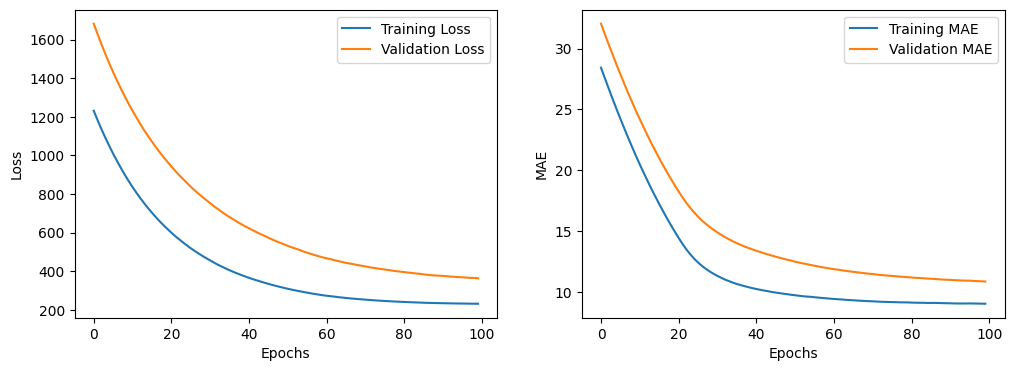

In [33]:
import matplotlib.pyplot as plt


# Evaluate the model
loss, mae = model.evaluate(mask_volume_test, TOS_volume_test)

# Plot the training and validation loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot the training and validation MAE
plt.subplot(1, 2, 2)
plt.plot(history.history['mean_absolute_error'], label='Training MAE')
plt.plot(history.history['val_mean_absolute_error'], label='Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

plt.show()

1/1 [==============================] - 19s 19s/step
Mean Squared Error on Test Set: 200.6504884004884
Sample 0
Predicted: [17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17
 17 17 18 18 18 18 19 19 20 21 21 22 23 25 26 27 29 30 32 33 35 36 38 39
 41 42 44 45 46 47 48 49 50 50 51 51 51 51 51 51 51 51 50 50 49 49 48 48
 47 46 45 44 43 42 41 40 38 37 36 35 33 32 31 29 28 27 26 26 25 24 23 23
 22 21 21 20 19 19 19 18 18 18 18 18 17 17 17 17 17 17 17 17 17 17 17 17
 17 17 17 17 17 17]
Actual: [17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17
 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 18 20 23 25 28 31 33
 36 39 42 44 47 49 51 53 55 56 58 59 61 62 63 64 64 65 65 66 66 67 67 67
 67 67 67 67 67 66 66 65 65 64 63 63 62 61 60 58 57 55 54 52 50 48 45 43
 40 37 35 32 28 26 23 20 18 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17
 17 17 17 17 17 17]

Sample 1
Predicted: [17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17
 17 17

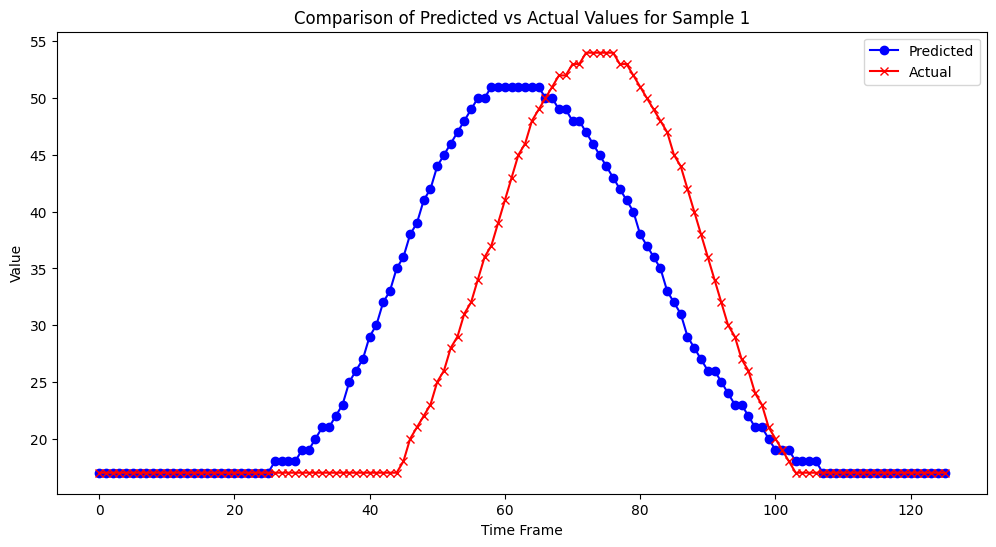

In [34]:
import numpy as np
from sklearn.metrics import mean_squared_error

# Assuming mask_volume_test is your test data and TOS_volume_test is the ground truth

# Make predictions
predictions = model.predict(mask_volume_test)

rounded_predictions = np.round(predictions).astype(int)


# Calculate Mean Squared Error
mse = mean_squared_error(TOS_volume_test_int, rounded_predictions)
print("Mean Squared Error on Test Set:", mse)

# Optionally, display some predictions and actual values
num_samples_to_display = 12  # You can adjust this number

for i in range(num_samples_to_display):
    print("Sample", i)
    print("Predicted:", rounded_predictions[i])
    print("Actual:", TOS_volume_test_int[i])
    print()

import matplotlib.pyplot as plt

# Select a sample to display
sample_index = 1  # Adjust this index to choose different samples

# Get the predicted and actual values for the selected sample
predicted_sample = rounded_predictions[sample_index]
actual_sample = TOS_volume_test_int[sample_index]

# Create a plot
plt.figure(figsize=(12, 6))
plt.plot(predicted_sample, label='Predicted', color='blue', marker='o')
plt.plot(actual_sample, label='Actual', color='red', marker='x')
plt.title(f"Comparison of Predicted vs Actual Values for Sample {sample_index}")
plt.xlabel('Time Frame')
plt.ylabel('Value')
plt.legend()
plt.show()

# VIT + LSTM

In [36]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.callbacks import EarlyStopping


def create_vit_model(num_frames, num_outputs):
    # URL for pre-trained Vision Transformer model from TensorFlow Hub
    vit_model_url = "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/feature_vector/2"

    # Load the Vision Transformer layer
    try:
        vit_layer = hub.KerasLayer(vit_model_url, trainable=True)
    except Exception as e:
        print(f"Error loading the model from TensorFlow Hub: {e}")
        return None

    # Define the input layer
    inputs = tf.keras.Input(shape=(80, 80, num_frames))

    # Reshaping and resizing input for ViT
    reshaped_input = tf.keras.layers.Reshape((num_frames, 80, 80, 1))(inputs)
    pseudo_rgb_input = tf.keras.layers.TimeDistributed(tf.keras.layers.Lambda(lambda x: tf.repeat(x, 3, axis=-1)))(reshaped_input)
    resized_input = tf.keras.layers.TimeDistributed(tf.keras.layers.Lambda(lambda x: tf.image.resize(x, [224, 224])))(pseudo_rgb_input)

    # TimeDistributed wrapper for the ViT layer
    time_distributed_vit = tf.keras.layers.TimeDistributed(vit_layer)

    # Process frames through the ViT layer
    vit_output = time_distributed_vit(resized_input)

    # Reshape the output for the LSTM layer
    # Assuming each frame after the ViT layer is transformed into a feature vector of a certain size,
    # reshape vit_output to have a shape of (batch_size, num_frames, features_per_frame)
    reshaped_vit_output = tf.keras.layers.Reshape((num_frames, -1))(vit_output)

    # LSTM layer for capturing temporal dependencies
    lstm_output = tf.keras.layers.LSTM(128)(reshaped_vit_output)


    # Final dense layer for regression output
    outputs = tf.keras.layers.Dense(num_outputs)(lstm_output)

    # Construct the model
    model = tf.keras.Model(inputs, outputs)
    return model


# Model parameters
num_frames = 25  # Based on your dataset
num_outputs = 126  # Based on your regression targets

# Create the model
model = create_vit_model(num_frames, num_outputs)

if model:
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])

    # EarlyStopping callback to stop training if validation MAE goes below 5.8
    # early_stopping_callback = EarlyStopping(monitor='val_mean_absolute_error', mode='min', verbose=1, baseline=5.8)

    # Fit the model
    history = model.fit(
        mask_volume_train,
        TOS_volume_train_int,
        epochs=100,
        batch_size=5,
        validation_split=0.1    )

Epoch 1/100
19/19 [==============================] - 51s 682ms/step - loss: 1176.9233 - mean_absolute_error: 27.5477 - val_loss: 1553.2898 - val_mean_absolute_error: 30.1410
Epoch 2/100
19/19 [==============================] - 11s 590ms/step - loss: 1036.1483 - mean_absolute_error: 24.8955 - val_loss: 1408.4071 - val_mean_absolute_error: 27.6314
Epoch 3/100
19/19 [==============================] - 11s 567ms/step - loss: 919.9163 - mean_absolute_error: 22.4256 - val_loss: 1283.3887 - val_mean_absolute_error: 25.3096
Epoch 4/100
19/19 [==============================] - 11s 566ms/step - loss: 821.2781 - mean_absolute_error: 20.1721 - val_loss: 1171.7767 - val_mean_absolute_error: 23.1117
Epoch 5/100
19/19 [==============================] - 11s 578ms/step - loss: 737.7962 - mean_absolute_error: 18.1496 - val_loss: 1080.7010 - val_mean_absolute_error: 21.2067
Epoch 6/100
19/19 [==============================] - 11s 577ms/step - loss: 667.8203 - mean_absolute_error: 16.3165 - val_loss: 999.5

1/1 [==============================] - 22s 22s/step - loss: 201.0401 - mean_absolute_error: 8.2203


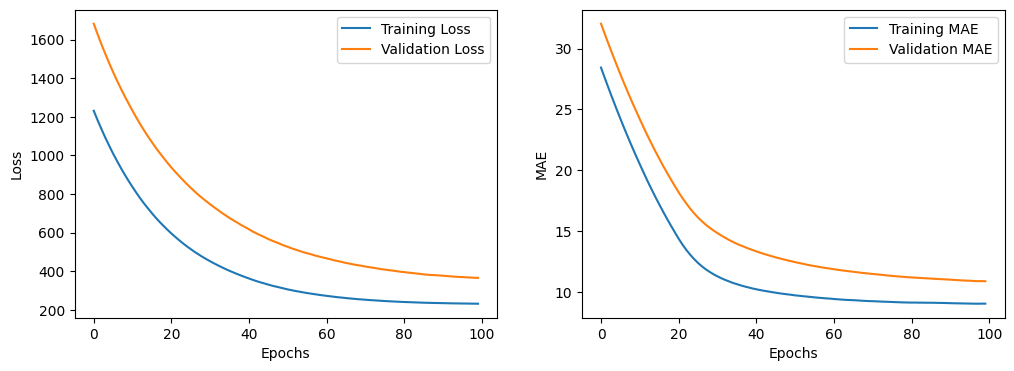

In [8]:
import matplotlib.pyplot as plt


# Evaluate the model
loss, mae = model.evaluate(mask_volume_test, TOS_volume_test)

# Plot the training and validation loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot the training and validation MAE
plt.subplot(1, 2, 2)
plt.plot(history.history['mean_absolute_error'], label='Training MAE')
plt.plot(history.history['val_mean_absolute_error'], label='Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

plt.show()

1/1 [==============================] - 2s 2s/step
Mean Squared Error on Test Set: 201.30189255189254
Sample 0
Predicted: [17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17
 17 17 18 18 18 18 19 19 20 21 22 22 24 25 26 28 29 31 32 34 35 37 39 40
 42 44 46 48 49 51 52 53 55 55 56 56 56 57 57 56 56 55 55 54 53 52 51 50
 49 48 47 46 44 43 42 40 39 37 36 34 33 32 30 29 28 27 26 26 25 24 23 22
 22 21 21 20 20 19 19 18 18 18 18 18 18 18 17 17 17 17 17 17 17 17 17 17
 17 17 17 17 17 17]
Actual: [17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17
 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 18 20 23 25 28 31 33
 36 39 42 44 47 49 51 53 55 56 58 59 61 62 63 64 64 65 65 66 66 67 67 67
 67 67 67 67 67 66 66 65 65 64 63 63 62 61 60 58 57 55 54 52 50 48 45 43
 40 37 35 32 28 26 23 20 18 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17
 17 17 17 17 17 17]

Sample 1
Predicted: [17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17
 17 17 

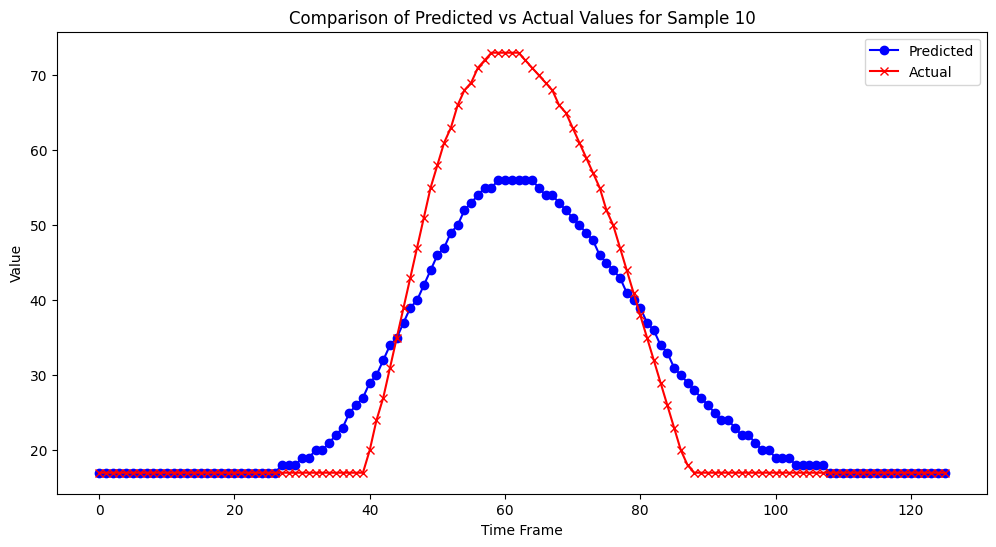

In [37]:
import numpy as np
from sklearn.metrics import mean_squared_error

# Assuming mask_volume_test is your test data and TOS_volume_test is the ground truth

# Make predictions
predictions = model.predict(mask_volume_test)

rounded_predictions = np.round(predictions).astype(int)


# Calculate Mean Squared Error
mse = mean_squared_error(TOS_volume_test_int, rounded_predictions)
print("Mean Squared Error on Test Set:", mse)

# Optionally, display some predictions and actual values
num_samples_to_display = 12  # You can adjust this number

for i in range(num_samples_to_display):
    print("Sample", i)
    print("Predicted:", rounded_predictions[i])
    print("Actual:", TOS_volume_test_int[i])
    print()

import matplotlib.pyplot as plt

# Select a sample to display
sample_index = 10  # Adjust this index to choose different samples

# Get the predicted and actual values for the selected sample
predicted_sample = rounded_predictions[sample_index]
actual_sample = TOS_volume_test_int[sample_index]

# Create a plot
plt.figure(figsize=(12, 6))
plt.plot(predicted_sample, label='Predicted', color='blue', marker='o')
plt.plot(actual_sample, label='Actual', color='red', marker='x')
plt.title(f"Comparison of Predicted vs Actual Values for Sample {sample_index}")
plt.xlabel('Time Frame')
plt.ylabel('Value')
plt.legend()
plt.show()

# VIT + LSTM (Same but more Deeper Network)

In [58]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.callbacks import EarlyStopping


def create_vit_model(num_frames, num_outputs):
    # URL for pre-trained Vision Transformer model from TensorFlow Hub
    vit_model_url = "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/feature_vector/2"

    # Load the Vision Transformer layer
    try:
        vit_layer = hub.KerasLayer(vit_model_url, trainable=True)
    except Exception as e:
        print(f"Error loading the model from TensorFlow Hub: {e}")
        return None

    # Define the input layer
    inputs = tf.keras.Input(shape=(80, 80, num_frames))

    # Reshaping and resizing input for ViT
    reshaped_input = tf.keras.layers.Reshape((num_frames, 80, 80, 1))(inputs)
    pseudo_rgb_input = tf.keras.layers.TimeDistributed(tf.keras.layers.Lambda(lambda x: tf.repeat(x, 3, axis=-1)))(reshaped_input)
    resized_input = tf.keras.layers.TimeDistributed(tf.keras.layers.Lambda(lambda x: tf.image.resize(x, [224, 224])))(pseudo_rgb_input)


    # TimeDistributed wrapper for the ViT layer
    time_distributed_vit = tf.keras.layers.TimeDistributed(vit_layer)

    # Process frames through the ViT layer
    vit_output = time_distributed_vit(resized_input)

    # Reshape the output for the LSTM layer
    reshaped_vit_output = tf.keras.layers.Reshape((num_frames, -1))(vit_output)

    # First LSTM layer for capturing temporal dependencies
    lstm_output_1 = tf.keras.layers.LSTM(128, return_sequences=True)(reshaped_vit_output)

    # Optionally add dropout for regularization
    dropout_1 = tf.keras.layers.Dropout(0.5)(lstm_output_1)

    # Second LSTM layer
    lstm_output_2 = tf.keras.layers.LSTM(128)(dropout_1)

    # Optionally add dropout for regularization
    dropout_2 = tf.keras.layers.Dropout(0.5)(lstm_output_2)

    # First Dense layer
    dense_output_1 = tf.keras.layers.Dense(64, activation='relu')(dropout_2)

    # Optionally add dropout for regularization
    dropout_3 = tf.keras.layers.Dropout(0.5)(dense_output_1)

    # Final dense layer for regression output
    outputs = tf.keras.layers.Dense(num_outputs)(dropout_3)

    # Construct the model
    model = tf.keras.Model(inputs, outputs)
    return model

# Model parameters
num_frames = 25  # Based on your dataset
num_outputs = 126  # Based on your regression targets

# Create the model
model = create_vit_model(num_frames, num_outputs)

if model:
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])

    # EarlyStopping callback to stop training if validation MAE goes below 5.8
    # early_stopping_callback = EarlyStopping(monitor='val_mean_absolute_error', mode='min', verbose=1, baseline=5.8)

    # Fit the model
    history = model.fit(
        mask_volume_train,
        TOS_volume_train_int,
        epochs=100,
        batch_size=5,
        validation_split=0.1    )

Epoch 1/100
19/19 [==============================] - 52s 636ms/step - loss: 1208.3390 - mean_absolute_error: 28.0349 - val_loss: 1598.6600 - val_mean_absolute_error: 30.7279
Epoch 2/100
19/19 [==============================] - 11s 569ms/step - loss: 1023.2316 - mean_absolute_error: 24.3483 - val_loss: 1282.7136 - val_mean_absolute_error: 25.0174
Epoch 3/100
19/19 [==============================] - 11s 574ms/step - loss: 756.3661 - mean_absolute_error: 18.1863 - val_loss: 887.3145 - val_mean_absolute_error: 17.2837
Epoch 4/100
19/19 [==============================] - 11s 578ms/step - loss: 479.9920 - mean_absolute_error: 14.0028 - val_loss: 589.6667 - val_mean_absolute_error: 14.6735
Epoch 5/100
19/19 [==============================] - 11s 566ms/step - loss: 364.2577 - mean_absolute_error: 12.8988 - val_loss: 444.3690 - val_mean_absolute_error: 12.2307
Epoch 6/100
19/19 [==============================] - 11s 591ms/step - loss: 315.9407 - mean_absolute_error: 12.4760 - val_loss: 383.7254

1/1 [==============================] - 2s 2s/step - loss: 200.6073 - mean_absolute_error: 8.1491


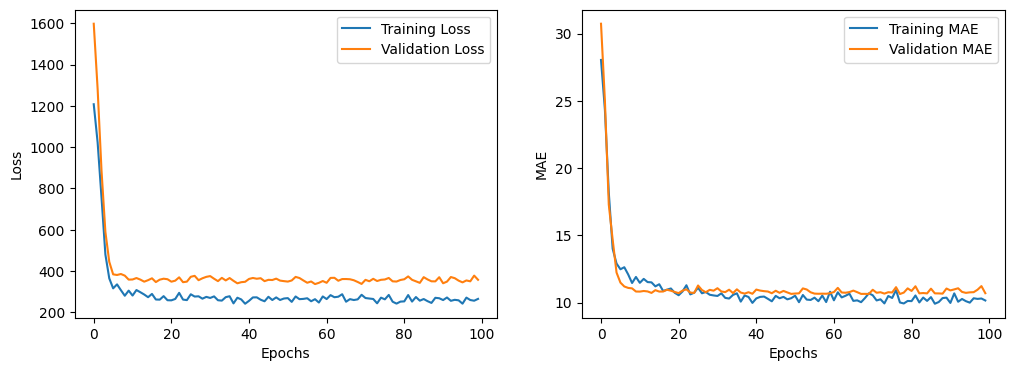

In [59]:
import matplotlib.pyplot as plt


# Evaluate the model
loss, mae = model.evaluate(mask_volume_test, TOS_volume_test)

# Plot the training and validation loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot the training and validation MAE
plt.subplot(1, 2, 2)
plt.plot(history.history['mean_absolute_error'], label='Training MAE')
plt.plot(history.history['val_mean_absolute_error'], label='Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

plt.show()

1/1 [==============================] - 2s 2s/step
Mean Squared Error on Test Set: 200.67735042735043
Sample 0
Predicted: [17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17
 17 17 18 18 18 19 19 19 20 21 22 22 24 25 26 27 29 30 31 33 34 36 38 40
 41 43 45 46 47 49 50 51 52 53 53 54 54 54 54 54 53 53 53 52 51 50 49 48
 47 46 45 44 43 41 40 39 37 36 35 33 32 31 29 28 27 26 25 24 24 23 22 21
 21 20 19 19 19 18 18 18 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17
 17 17 17 17 17 17]
Actual: [17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17
 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 18 20 23 25 28 31 33
 36 39 42 44 47 49 51 53 55 56 58 59 61 62 63 64 64 65 65 66 66 67 67 67
 67 67 67 67 67 66 66 65 65 64 63 63 62 61 60 58 57 55 54 52 50 48 45 43
 40 37 35 32 28 26 23 20 18 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17
 17 17 17 17 17 17]

Sample 1
Predicted: [17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17
 17 17 

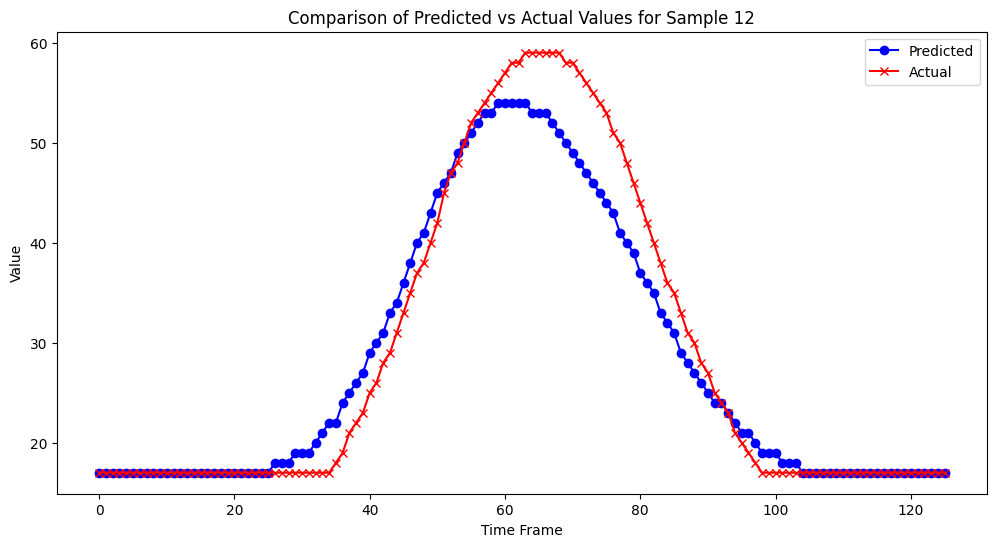

In [60]:
import numpy as np
from sklearn.metrics import mean_squared_error

# Assuming mask_volume_test is your test data and TOS_volume_test is the ground truth

# Make predictions
predictions = model.predict(mask_volume_test)

rounded_predictions = np.round(predictions).astype(int)


# Calculate Mean Squared Error
mse = mean_squared_error(TOS_volume_test_int, rounded_predictions)
print("Mean Squared Error on Test Set:", mse)

# Optionally, display some predictions and actual values
num_samples_to_display = 12  # You can adjust this number

for i in range(num_samples_to_display):
    print("Sample", i)
    print("Predicted:", rounded_predictions[i])
    print("Actual:", TOS_volume_test_int[i])
    print()

import matplotlib.pyplot as plt

# Select a sample to display
sample_index = 12 # Adjust this index to choose different samples

# Get the predicted and actual values for the selected sample
predicted_sample = rounded_predictions[sample_index]
actual_sample = TOS_volume_test_int[sample_index]

# Create a plot
plt.figure(figsize=(12, 6))
plt.plot(predicted_sample, label='Predicted', color='blue', marker='o')
plt.plot(actual_sample, label='Actual', color='red', marker='x')
plt.title(f"Comparison of Predicted vs Actual Values for Sample {sample_index}")
plt.xlabel('Time Frame')
plt.ylabel('Value')
plt.legend()
plt.show()

# Combination 3D CNN + ViT (Not Part of the project, Just for fun)

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Define 3D CNN
def create_3d_cnn(input_shape, feature_dim):
    model = models.Sequential()
    model.add(layers.Conv3D(128, (3, 3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling3D((2, 2, 2)))
    model.add(layers.Conv3D(128, (3, 3, 3), activation='relu'))
    model.add(layers.MaxPooling3D((2, 2, 2)))
    model.add(layers.Conv3D(256, (3, 3, 3), activation='relu'))
    model.add(layers.GlobalAveragePooling3D())
    model.add(layers.Dropout(0.3))  # Dropout for regularization
    model.add(layers.Dense(feature_dim, activation='relu'))
    return model

# Transformer Encoder Layer
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerEncoder, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential([
            layers.Dense(ff_dim, activation="relu"),
            layers.Dense(embed_dim),
        ])
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

# Vision Transformer Model
def create_vision_transformer(num_patches, embed_dim, num_heads, ff_dim, num_transformer_layers, num_outputs):
    inputs = layers.Input(shape=(num_patches, embed_dim))
    positions = tf.range(start=0, limit=num_patches, delta=1)
    positional_embedding = layers.Embedding(input_dim=num_patches, output_dim=embed_dim)(positions)
    x = inputs + positional_embedding

    for _ in range(num_transformer_layers):
        x = TransformerEncoder(embed_dim, num_heads, ff_dim)(x)

    x = layers.GlobalAveragePooling1D()(x)
    outputs = layers.Dense(num_outputs)(x)
    return models.Model(inputs=inputs, outputs=outputs)

# Combined 3D CNN + ViT Model
def create_combined_model(input_shape, num_outputs, feature_dim, num_transformer_layers):
    cnn_model = create_3d_cnn(input_shape, feature_dim)

    # Parameters for ViT
    num_patches = 256  # This should match with the output of CNN
    embed_dim = 128  # Embedding dimension for each patch
    num_heads = 8  # Number of attention heads
    ff_dim = 512  # Dimension of feed-forward layer

    vit_model = create_vision_transformer(num_patches, embed_dim, num_heads, ff_dim, num_transformer_layers, num_outputs)

    combined_input = layers.Input(shape=input_shape)
    x = cnn_model(combined_input)
    x = layers.Reshape((num_patches, -1))(x)  # Reshape for ViT
    outputs = vit_model(x)

    model = models.Model(inputs=combined_input, outputs=outputs)
    return model

# Model parameters
input_shape = (80, 80, 25, 1)
num_outputs = 126
feature_dim = 256  # This should be adjusted based on the CNN output
num_transformer_layers = 4  # Number of transformer layers

# Create and compile the model
model = create_combined_model(input_shape, num_outputs, feature_dim, num_transformer_layers)
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])

# Fit the model to the training data
history = model.fit(mask_volume_train, TOS_volume_train_int, epochs=120, batch_size=10, validation_split=0.05)

# Evaluate the model
model.evaluate(mask_volume_test, TOS_volume_test_int)


In [ ]:
import matplotlib.pyplot as plt


# Evaluate the model
loss, mae = model.evaluate(mask_volume_test, TOS_volume_test)

# Plot the training and validation loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot the training and validation MAE
plt.subplot(1, 2, 2)
plt.plot(history.history['mean_absolute_error'], label='Training MAE')
plt.plot(history.history['val_mean_absolute_error'], label='Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

plt.show()

In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error

# Assuming mask_volume_test is your test data and TOS_volume_test is the ground truth
model.evaluate(mask_volume_test, TOS_volume_test_int)

# Make predictions
predictions = model.predict(mask_volume_test)

rounded_predictions = np.round(predictions).astype(int)


# Calculate Mean Squared Error
mse = mean_squared_error(TOS_volume_test_int, rounded_predictions)
print("Mean Squared Error on Test Set:", mse)

# Optionally, display some predictions and actual values
num_samples_to_display = 5  # You can adjust this number

for i in range(num_samples_to_display):
    print("Sample", i)
    print("Predicted:", rounded_predictions[i])
    print("Actual:", TOS_volume_test_int[i])
    print()

import matplotlib.pyplot as plt

# Select a sample to display
sample_index = 1  # Adjust this index to choose different samples

# Get the predicted and actual values for the selected sample
predicted_sample = rounded_predictions[sample_index]
actual_sample = TOS_volume_test_int[sample_index]

# Create a plot
plt.figure(figsize=(12, 6))
plt.plot(predicted_sample, label='Predicted', color='blue', marker='o')
plt.plot(actual_sample, label='Actual', color='red', marker='x')
plt.title(f"Comparison of Predicted vs Actual Values for Sample {sample_index}")
plt.xlabel('Time Frame')
plt.ylabel('Value')
plt.legend()
plt.show()